# Item-Based Memory Model

This notebook looks at building an item-item collaborative filtering model using the `movielens` dataset. If you wish to understand the theory behind item-item models please refer to the `01_intro` notebook.

In [32]:
from typing import (
    Tuple,
    Union
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity

Read in the data into a dataframe:

In [5]:
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', header=None)
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_titles = pd.read_csv('./ml-100k/u.item', sep='|', header=None, encoding="ISO-8859-1")
movie_titles.columns = """movie_id | movie_title | release_date | video_release_date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Childrens | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western""".replace('\n', '').replace(' ', '').split('|')

In [6]:
ratings = pd.merge(ratings, movie_titles[['movie_id', 'movie_title']], left_on='movie_id', right_on='movie_id')
ratings

,user_id,movie_id,rating,timestamp,movie_title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
...,...,...,...,...,...
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."


How many unique items (movies in this case) do we have:

In [7]:
np.unique(ratings.movie_id).shape

(1682,)

Create a pivot table to with movies as rows and users as columns

In [8]:
item_user = ratings.pivot_table(index='movie_id', columns='user_id', values='rating')
item_user

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Subtract the mean rating for each user for the movies they rated and fill in the empties with zero. This results in the mean for each user being zero allowing us to fill in the `NA`s with zero.

In [9]:
item_user_cosine_adjusted = item_user - item_user.mean(axis=0)
item_user_cosine_adjusted = item_user_cosine_adjusted.fillna(0)

In [10]:
item_user_cosine_adjusted

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,0.290323,0.0,0.0,1.125714,0.364929,0.000000,0.0,0.0,-0.206522,...,-1.701149,-0.923077,0.253521,0.0,0.731481,0.0,0.000000,0.954545,0.0,0.000000
2,-0.610294,0.000000,0.0,0.0,0.125714,0.000000,0.000000,0.0,0.0,0.000000,...,0.298851,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.589286
3,0.389706,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.253521,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
4,-0.610294,0.000000,0.0,0.0,0.000000,0.000000,1.034739,0.0,0.0,-0.206522,...,1.298851,0.000000,0.000000,0.0,0.000000,0.0,-1.457944,0.000000,0.0,0.000000
5,-0.610294,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1679,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1680,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


Create an item-item similarity matrix scoring via cosine similarity

In [11]:
item_item_sim = pd.DataFrame(cosine_similarity(item_user_cosine_adjusted, item_user_cosine_adjusted), columns=item_user_cosine_adjusted.index, index=item_user_cosine_adjusted.index)
item_item_sim

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.058367,-0.065560,-0.039649,0.011691,0.027294,0.074627,0.127370,0.038487,0.004889,...,0.060065,0.0,0.000000,0.000000,0.011100,0.0,0.0,0.0,0.053377,-0.033203
2,-0.058367,1.000000,0.033551,0.031268,0.013884,-0.010781,-0.054500,-0.008301,-0.105092,-0.020407,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.001926,0.036452
3,-0.065560,0.033551,1.000000,-0.117538,0.013721,0.053766,-0.088374,-0.150728,-0.067389,-0.049810,...,0.000000,0.0,0.000000,0.000000,0.200920,0.0,0.0,0.0,0.000000,0.033238
4,-0.039649,0.031268,-0.117538,1.000000,-0.150014,-0.023626,0.004446,0.110419,0.027818,0.010657,...,0.000000,0.0,-0.114405,-0.114405,0.089998,0.0,0.0,0.0,0.001436,-0.047084
5,0.011691,0.013884,0.013721,-0.150014,1.000000,-0.041925,-0.045006,0.011713,-0.062400,-0.032335,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.045630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
1680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000


In [12]:
item_item_sim_matrix = item_item_sim.to_numpy()

The functions below:
- **get_similar_items**: Obtains `k` similar items to the `item_id`. Returns the item IDs and the similarity score
- **predict_rating**: Predicts the rating for a given `user_id` and `item_id`. The rating is calculated via the weighted sum.

In [13]:
def get_similar_items(item_id: int, k: int=20) -> Tuple[np.array, np.array]:
    """
    Obtains the most similar items to a given item ID
    
    :type item_id: int
    :param item_id: ID of the movie
    :type k: int
    :param k: number of nearest neighbors
    :rtype: Tuple[np.array, np.array]
    :return: Indices of k most similar items along with the similarity score
    """
    item_row = item_item_sim_matrix[item_id - 1,]
    sim_indices = np.argsort(item_row)[::-1][1:k+1]
    sim_scores = item_row[sim_indices]
    return sim_indices + 1, sim_scores

def predict_rating(user_id: int, item_id: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_items, sim_scores = get_similar_items(item_id)
    user_rated_items = item_user[user_id].dropna()
    user_rated_filtered = [item in user_rated_items.index for item in sim_items]
    if np.any(user_rated_filtered):
        return np.dot(sim_scores[user_rated_filtered], user_rated_items.loc[sim_items[user_rated_filtered]]) / np.sum(sim_scores[user_rated_filtered])
    else:
        return None

In [14]:
get_similar_items(1)

(array([174, 588,  50,  28,  95, 210, 172,  64,  22, 181, 318,  71, 169,
        173,  98, 496,  96,  82, 423, 132], dtype=int64),
 array([0.27113089, 0.24023952, 0.23542587, 0.22905429, 0.21621116,
        0.20838653, 0.20048798, 0.19194437, 0.19087011, 0.19036094,
        0.1896913 , 0.18407121, 0.17710278, 0.17224644, 0.16915289,
        0.16753835, 0.16120849, 0.15825835, 0.15611137, 0.15201018]))

In [15]:
predict_rating(1, 1) # Actual is 5

4.506478173096579

Run the predictions on the data the similarity was calculated from.

In [16]:
true_ratings = []
pred_ratings = []
for row in ratings.itertuples():
    try:
        predicted_rating = predict_rating(row.user_id, row.movie_id)
        if predicted_rating:
            pred_ratings.append(predicted_rating)
            true_ratings.append(row.rating)
    except KeyError:
        continue
print(mean_absolute_error(true_ratings, pred_ratings))

0.6101624396755433


## Train and Test Set

The dataset come with a set of training and test sets. Let's evaluate the item-item model

The first thing to do is to read in the training data

In [17]:
training = pd.read_csv('./ml-100k/u1.base', sep='\t', header=None)
training.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

The next steps are the same as above:
- Create item-user table
- Cosine adjust the ratings
- Create item-item similarity matrix

In [18]:
item_user = training.pivot_table(index='movie_id', columns='user_id', values='rating')

item_user_cosine_adjusted = item_user - item_user.mean(axis=0)
item_user_cosine_adjusted = item_user_cosine_adjusted.fillna(0)

item_item_sim = pd.DataFrame(cosine_similarity(item_user_cosine_adjusted, item_user_cosine_adjusted), columns=item_user_cosine_adjusted.index, index=item_user_cosine_adjusted.index)

item_item_sim_matrix = item_item_sim.to_numpy()

Here, there is an additional step. Since we can't be sure that all the items in the training data are present in the test data we need to create a mapping of the item ID to row index in the item-item matrix

In [19]:
item_id_to_index = {i_id: i for i, i_id in enumerate(item_item_sim.index)}

The only difference here is that the `item_id` is looked up to find its corresponding row in the matrix:

In [20]:
def get_similar_items_test(item_index: int, k: int=20) -> Tuple[np.array, np.array]:
    """
    Obtains the most similar items to a given item ID
    
    :type item_index: int
    :param item_index: Index of the item in the similarity matrix
    :type k: int
    :param k: number of nearest neighbors
    :rtype: Tuple[np.array, np.array]
    :return: Indices of k most similar items along with the similarity score
    """
    item_row = item_item_sim_matrix[item_index,]
    sim_indices = np.argsort(item_row)[::-1][1:k+1]
    sim_scores = item_row[sim_indices]
    return sim_indices + 1, sim_scores

def predict_rating_test(user_id: int, item_id: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_items, sim_scores = get_similar_items_test(item_id_to_index[item_id])
    user_rated_items = item_user[user_id].dropna()
    user_rated_filtered = [item in user_rated_items.index for item in sim_items]
    if np.any(user_rated_filtered):
        return np.dot(sim_scores[user_rated_filtered], user_rated_items.loc[sim_items[user_rated_filtered]]) / np.sum(sim_scores[user_rated_filtered])
    else:
        return None

In [21]:
predict_rating_test(1,1)

4.6464585205215245

Run the model against the test data and calculate the error:

In [22]:
test_data = pd.read_csv('./ml-100k/u1.test', sep='\t', header=None)
test_data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

In [23]:
true_ratings = []
pred_ratings = []
for row in test_data.itertuples():
    try:
        predicted_rating = predict_rating_test(row.user_id, row.movie_id)
        if predicted_rating:
            pred_ratings.append(predicted_rating)
            true_ratings.append(row.rating)
    except KeyError:
        continue
print(mean_absolute_error(true_ratings, pred_ratings))

0.8005036399708397


## What is the Best K?

Above, I've arbitrarily chosen a K of 20. Is this the best value? Let's try a range of K:

In [24]:
# Same function as above, but now we can pass a K parameter
def predict_rating_test(user_id: int, item_id: int, k: int) -> Union[float, None]:
    """
    Predicts the rating of an item given a user
    
    :type user_id: int
    :param user_id: ID of the user
    :type item_id: int
    :param item_id: ID of the item to predict the rating of
    :rtype: Union[float, None]
    :return: Predicted rating of the item or None if the rating cannot be predicted
    """
    sim_items, sim_scores = get_similar_items_test(item_id_to_index[item_id], k=k)
    user_rated_items = item_user[user_id].dropna()
    user_rated_filtered = [item in user_rated_items.index for item in sim_items]
    if np.any(user_rated_filtered):
        return np.dot(sim_scores[user_rated_filtered], user_rated_items.loc[sim_items[user_rated_filtered]]) / np.sum(sim_scores[user_rated_filtered])
    else:
        return None

In [33]:
scores = []
for k in range(5, 30 + 1):
    true_ratings = []
    pred_ratings = []
    for row in test_data.itertuples():
        try:
            predicted_rating = predict_rating_test(row.user_id, row.movie_id, k)
            if predicted_rating:
                pred_ratings.append(predicted_rating)
                true_ratings.append(row.rating)
        except KeyError:
            continue
    scores.append(mean_absolute_error(true_ratings, pred_ratings))

Text(0, 0.5, 'MAE')

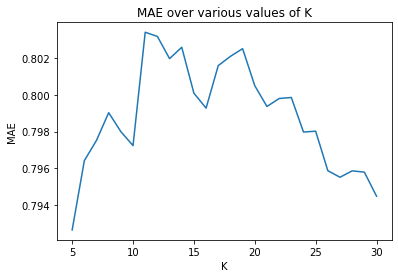

In [38]:
sns.lineplot(range(5, 30 + 1), scores)
plt.title('MAE over various values of K')
plt.xlabel('K')
plt.ylabel('MAE')

Interesting to see a large variation, although the range on the y-axis is rather small. Generally speaking at around k=20 increasing the number of neighbours leads to an improvement in the predictions.